# GRT Final

This is the final development notebook of the GRT project.  In this notebook converge all the lessons learned during development.

In [41]:
import os
NTH=4
os.environ["OMP_NUM_THREADS"]="%d"%NTH

In [42]:
from gravray import *
from gravray.util import *
from gravray.stats import *
from gravray.spice import *
from gravray.plot import *
from gravray.sampling import *
from gravray.orbit import *

import skmonaco
import multiprocessing as mp

In [43]:
%matplotlib nbagg

## Initialize

In [45]:
dt=elTime(0)
Spice.loadKernels()
cneos=pd.read_csv("data/cneos_fireball_data_location.csv")
cneos.set_index("Name",inplace=True)
earth=Body("EARTH")
NP=int(mp.cpu_count()/NTH)
print("Available number of processors: ",NP)

Available number of processors:  1


## Example conditions

In [6]:
#Site 
lon=59.8703**Angle.Deg #rad
lat=55.0958*Angle.Deg #rad
alt=23.3*Const.km #m

#Time
datestring="02/15/2013 03:20:34"
fmt="%m/%d/%Y %H:%M:%S"
t=Spice.str2tdb(datestring)

#Population
weights=[0.6]
locs=[
    [0.5,0.5,-2.0],
    [2.0,0.3,-2.6]
]
scales=[
    [1.3,0.7,0.5],
    [0.4,0.9,1.6]
]
angles=[
    [-40.0*Angle.Deg,-86.0*Angle.Deg,0.0*Angle.Deg],
    [+80.0*Angle.Deg,-109.0*Angle.Deg,0.0*Angle.Deg]
]
ranges=[
    [Util.fin2Inf(1e-2,360.0),Util.fin2Inf(360.0-1e-2,360.0)],
    [Util.fin2Inf(1e-2,360.0),Util.fin2Inf(360.0-1e-2,360.0)]
]
NEOs=MultiVariate([1,1,1,0,0])
NEOs.setUnflatten(weights,locs,scales,angles,ranges)

#Direction
Aloc=103.5*Angle.Deg
hloc=18.55*Angle.Deg
vimp=-18.6*Const.km/Const.s

Rdir=np.array([[Aloc],[hloc],[vimp]])

#Input conditions
print(f"Impact conditions:")
print(f"\tDate: {datestring}")
print(f"\tlon. {lon*Angle.Rad:.4g}, lat. {lat*Angle.Rad:.4g}, alt. {alt/Const.km:.4g} km")
print(f"\tAloc = {Aloc*Angle.Rad:.4g}, hloc = {lat*Angle.Rad:.4g}, vimp = {vimp/Const.km} km/s")

Impact conditions:
	Date: 02/15/2013 03:20:34
	lon. 61.54, lat. 55.1, alt. 23.3 km
	Aloc = 103.5, hloc = 55.1, vimp = -18.6 km/s


## Test routines

In [7]:
prob=GrtProb(t,earth,NEOs,verbose=True)
prob.setLocation(lon,lat,alt)
p=prob.calcPdir([Aloc,hloc,vimp])
p,prob.ph,prob.detJ,prob.Rdir

Impact conditions: np.array([[1.806415775814131],[0.32375857624494814],[-18600.0]])
Terminal elements: [  0.72231578   0.5297087    5.18079402 326.57568287 103.0150748
  24.56944643]
Unbound terminal elements: [ 0.89757661  0.11897496 -3.518794    2.27937803 -0.91414209 -2.61391129]


(5.228572267234881e-26,
 5.586619321805399e-05,
 -9.359098886202953e-22,
 [1.806415775814131, 0.32375857624494814, -18600.0])

In [8]:
prob=GrtProb(t,earth,NEOs,verbose=False)
prob.setLocation(lon,lat,alt)
p=prob.calcPsky(np.array([[Aloc],[hloc],[vimp]]))
p,prob.phs,prob.detJs,prob.selements,prob.Rsky

(array([5.22857227e-26]),
 array([5.58661932e-05]),
 array([-9.35909889e-22]),
 array([[  0.72231578,   0.5297087 ,   5.18079402, 326.57568287,
         103.0150748 ,  24.56944643]]),
 array([[ 1.80641578e+00,  3.23758576e-01, -1.86000000e+04]]))

In [9]:
prob=GrtProb(t,earth,NEOs,verbose=False)
p=prob.calcPimp(np.array([[lon],[lat],[alt],[Aloc],[hloc],[vimp]]))
p,prob.phs,prob.detJs,prob.selements,prob.Rimp

(array([5.22857227e-26]),
 array([5.58661932e-05]),
 array([-9.35909889e-22]),
 array([[  0.72231578,   0.5297087 ,   5.18079402, 326.57568287,
         103.0150748 ,  24.56944643]]),
 array([[ 1.07403440e+00,  9.61603114e-01,  2.33000000e+04,
          1.80641578e+00,  3.23758576e-01, -1.86000000e+04]]))

## Test integrations

### One dimensional integation (quad)

In [10]:
pint=MultiQuad(prob.calcPsky,["A","h","v"],integrator="quad")
i,di=pint.integrate({"A":[np.pi],"h":[np.pi/4],"v":np.array([-43.3,-11.1])*Const.km/Const.s})
print(f"Integral in one direction (integrator '{pint.nintegrator}'):",i,di,pint.fun_calls)

Integral in one direction (integrator 'quad'): 3.539251483977331e-23 3.2858412673551106e-23 21


### Two dimensional

In [11]:
pint=MultiQuad(prob.calcPsky,["A","h","v"],integrator="fixed_quad")
dt=elTime(0)
i,di=pint.integrate({"A":[0,2*np.pi],"h":[0,np.pi/2],"v":np.array([-18.6])*Const.km/Const.s})
dt=elTime(1)
print(f"Integral in two directions (integrator '{pint.nintegrator}'):",i,di,pint.fun_calls)

Elapsed time since last call: 133.912 ms
Integral in two directions (integrator 'fixed_quad'): 1.060624924834944e-25 None 5


### Three dimensional (approximate)

In [12]:
prob=GrtProb(t,earth,NEOs,verbose=False)
prob.setLocation(lon,lat,alt)
pint=MultiQuad(prob.calcPsky,["A","h","v"],integrator="fixed_quad",opt=dict(n=37))
dt=elTime(0)
i,di=pint.integrate({"A":[0,2*np.pi],"h":[0,np.pi/2],"v":np.array([-72.2,-11.1])*Const.km/Const.s})
dt=elTime(1)
print(i,di,pint.fun_calls)
print(f"Integral in three directions (integrator '{pint.nintegrator}'):",i,di,pint.fun_calls)

Elapsed time since last call: 592.452 ms
2.0715599473990289e-22 None 37
Integral in three directions (integrator 'fixed_quad'): 2.0715599473990289e-22 None 37


In [13]:
nint=MultiCube(prob.calcPsky,["A","h","v"])
dt=elTime(0)
i=nint.integrate({"A":[0,2*np.pi],"h":[0,np.pi/2],"v":np.array([-72.2,-11.1])*Const.km/Const.s})
dt=elTime(1)
print(f"Integral in three directions (integrator '{nint.nscheme}'):",i)

Elapsed time since last call: 504.775 ms
Integral in three directions (integrator 'dobrodeev_1978'): 1.6894810998515917e-21


### Three dimensional (exhaustive)

In [18]:
prob=GrtProb(t,earth,NEOs,verbose=False)
prob.setLocation(lon,lat,alt)
NCALLS=0
def fquad(*X):
    global NCALLS
    A,h,v=X
    p=prob.calcPdir([A,h,v])
    NCALLS+=1
    if (NCALLS%10000)==0:
        print(f"{NCALLS} calls... ")
        dt=elTime(1)
    return p

In [ ]:
print(datetime.now())
dt=elTime(0)
#i=integrate.nquad(fquad,[[0,2*np.pi],[0,np.pi/2],np.array([-72.2,-11.1])*Const.km/Const.s],full_output=True)
dt=elTime(1)
print(datetime.now())
print(f"Integral in three directions (exhaustive):",i)

### Two dimensional (Monte Carlo)

In [46]:
NCALLS=0
def fmc2(X):
    global NCALLS
    A,h=X
    v=-18.6*Const.km/Const.s
    p=prob.calcPdir([A,h,v])
    NCALLS+=1
    if (NCALLS%1000)==0:
        print(f"{NCALLS} calls... ")
        dt=elTime(1)
    return p

In [47]:
NCALLS=0
N=int(1000/NP)*NP
B=int(N/NP)
print(f"Integrating with {N} points in batches of {B} points")
dt=elTime(0)
integ=skmonaco.mcquad(fmc2,npoints=N,
                      xl=[0.0,0.0],
                      xu=[2*np.pi,np.pi/2],
                      nprocs=NP,batch_size=B)
dt=elTime(1)
print("Two dimensional simple MC: ",integ)

Integrating with 1000 points in batches of 1000 points
1000 calls... 
Elapsed time since last call: 39.1627 s
Elapsed time since last call: 162.125 us
Two dimensional simple MC:  (1.3786110316747685e-25, 4.2847973139794553e-26)


In [38]:
NCALLS=0
N=int(1000/NP)*NP
print(f"Integrating with {N} points")
dt=elTime(0)
integ=skmonaco.mcmiser(fmc2,npoints=N,
                       xl=[0.0,0.0],
                       xu=[2*np.pi,np.pi/2],
                       nprocs=NP)
dt=elTime(1)
print("Two dimensional MISER MC: ",integ)

Integrating with 999 points
Elapsed time since last call: 15.8231 s
Two dimensional MISER MC:  (9.630383939904805e-26, 1.1156840588569277e-26)


### Three dimensional (Monte Carlo)

In [24]:
NCALLSF=0
def fmc3(X):
    global NCALLSF
    A,h,v=X
    p=prob.calcPdir([A,h,v])
    NCALLSF+=1
    if (NCALLSF%1000)==0:
        print(f"{NCALLSF} calls... ",)
        dt=elTime(1)
    return p

In [39]:
NCALLSF=0
N=int(10000/NP)*NP
B=int(N/NP)
print(f"Integrating with {N} points in batches of {B} points")
dt=elTime(0)
integ=skmonaco.mcquad(fmc3,npoints=N,
                      xl=[0.0,0.0,-72.2*Const.km/Const.s],
                      xu=[2*np.pi,np.pi/2,-11.1*Const.km/Const.s],
                      nprocs=NP,batch_size=B)
dt=elTime(1)
print("Three dimensional simple MC: ",integ,NCALLSF)

100 calls... 
Elapsed time since last call: 1.63707 s
200 calls... 
Elapsed time since last call: 1.32001 s
300 calls... 
Elapsed time since last call: 2.03979 s
400 calls... 
Elapsed time since last call: 2.16939 s
500 calls... 
Elapsed time since last call: 1.74412 s
600 calls... 
Elapsed time since last call: 1.78554 s
700 calls... 
Elapsed time since last call: 1.63134 s
800 calls... 
Elapsed time since last call: 1.44536 s
900 calls... 
Elapsed time since last call: 1.51156 s
1000 calls... 
Elapsed time since last call: 1.97176 s
1100 calls... 
Elapsed time since last call: 1.71927 s
1200 calls... 
Elapsed time since last call: 1.50401 s


Process Process-19:
  File "/Users/jzuluaga/anaconda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/Users/jzuluaga/anaconda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/jzuluaga/anaconda/lib/python3.6/site-packages/skmonaco/mp.py", line 19, in fun
    q_out.put((i,f(x)))
  File "/Users/jzuluaga/anaconda/lib/python3.6/site-packages/skmonaco/uniform.py", line 41, in func
    xl,xu,args=self.args,rng=self.rng,seed=seed)
  File "_mc.pyx", line 89, in skmonaco._mc.integrate_uniform (skmonaco/_mc.c:2677)


KeyboardInterrupt: 

  File "_mc.pyx", line 36, in skmonaco._mc.run_integral (skmonaco/_mc.c:1546)
  File "_core.pyx", line 40, in skmonaco._core.mc_kernel_noargs (skmonaco/_core.c:1757)
  File "<ipython-input-24-b10eacf2e845>", line 5, in fmc3
    p=prob.calcPdir([A,h,v])
  File "/Users/jzuluaga/GoogleDrive/ColaboratoryProjects/GRT2/GRT/gravray/orbit.py", line 811, in calcPdir
    detJ=ray.calcJacobianDeterminant()*                     (1-ray.terminal.elements[1])*                     Jacobians.calcDetMapJacobian(ray.terminal.elements,
  File "/Users/jzuluaga/GoogleDrive/ColaboratoryProjects/GRT2/GRT/gravray/orbit.py", line 709, in calcJacobianDeterminant
    y,Jhx=Jacobians.computeNumericalJacobian(Xbody2Xhel,X,dX)
  File "/Users/jzuluaga/GoogleDrive/ColaboratoryProjects/GRT2/GRT/gravray/orbit.py", line 349, in computeNumericalJacobian
    dyidxj=(yi(x[j]+dx[j])-yi(x[j]-dx[j]))/(2*dx[j])
  File "/Users/jzuluaga/GoogleDrive/ColaboratoryProjects/GRT2/GRT/gravray/orbit.py", line 348, in <lambda>
    yi=lamb

In [ ]:
NCALLSF=0
N=int(10000/NP)*NP
dt=elTime(0)
integ=skmonaco.mcmiser(fmc3,npoints=N,
                      xl=[0.0,0.0,-72.2*Const.km/Const.s],
                      xu=[2*np.pi,np.pi/2,-11.1*Const.km/Const.s],
                      nprocs=NP)
dt=elTime(1)
print("Three dimensional MISER MC: ",integ,NCALLSF)

--End--

In [1]:
"""
pint=MultiQuad(prob.calcPsky,["A","h","v"],integrator="quad")
dt=elTime(0)
i,di=pint.integrate({"A":[0,2*np.pi],"h":[0,np.pi/2],"v":np.array([-18.6])*Const.km/Const.s})
dt=elTime(1)
print(f"Integral in three directions (integrator '{pint.nintegrator}'):",i,di,pint.fun_calls)
pint=MultiQuad(prob.calcPsky,["A","h","v"],integrator="quad")
dt=elTime(0)
i,di=pint.integrate({"A":[0,2*np.pi],"h":[0,np.pi/2],"v":np.array([-18.6])*Const.km/Const.s})
dt=elTime(1)
print(i,di,pint.fun_calls)
pint=MultiQuad(prob.calcPsky,["A","h","v"],integrator="quad")
dt=elTime(0)
i,di=pint.integrate({"A":[0,2*np.pi],"h":[0,np.pi/2],"v":np.array([-72.2,-11.1])*Const.km/Const.s})
dt=elTime(1)
print(i,di,pint.fun_calls)
"""
1

1

## Two dimensional Monte Carlo with pregenerated points

In [118]:
vimp=-18.6*Const.km/Const.s
f=lambda X:prob.calcPdir([X[0],X[1],vimp])

points=[]
def f(X):
    global points
    points+=[list(X)]
    return prob.calcPdir([X[0],X[1],vimp])

In [168]:
N=5000
points=[]
dt=elTime(0)
integ=skmonaco.mcmiser(f,npoints=N,
                       xl=[0.0,0.0],
                       xu=[2*np.pi,np.pi/2],
                       nprocs=NP)
dt=elTime(1)
print(integ)

Elapsed time since last call: 2.61356 min
(1.0903922277384377e-25, 6.311961039484685e-27)


<IPython.core.display.Javascript object>


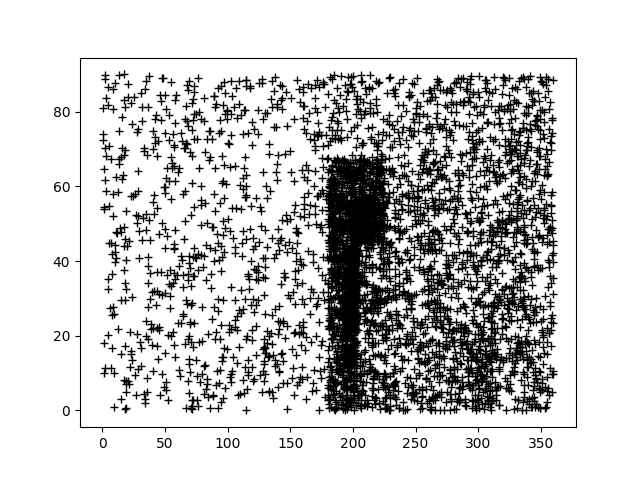

In [171]:
points=np.array(points)
points.shape
fig=plt.figure()
ax=fig.gca()
ax.plot(points[:,0]*Angle.Rad,points[:,1]*Angle.Rad,'k+')

In [166]:
points=[]
N=5000
dt=elTime(0)
integ=skmonaco.mcquad(f,npoints=N,
                       xl=[0.0,0.0],
                       xu=[2*np.pi,np.pi/2],
                       nprocs=NP)
dt=elTime(1)
print(integ)

Elapsed time since last call: 2.55165 min
(1.7262327661211382e-25, 5.349219802815071e-26)


In [147]:
V=(spoints[:,0].max()-spoints[:,0].min())*(spoints[:,1].max()-spoints[:,1].min())
V=np.pi**2

In [148]:
spoints=np.copy(points)
points=[]
dt=elTime(0)
integ=skmonaco.integrate_from_points(f,spoints)
dt=elTime(1)
print(integ[0]*V,integ[1]*V)

Elapsed time since last call: 33.1117 s
8.481501331220192e-26 1.0814998198742245e-26


<IPython.core.display.Javascript object>


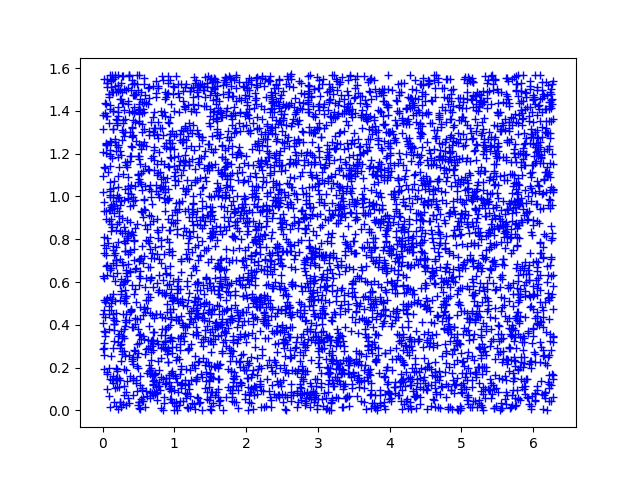

In [167]:
points=np.array(points)
points.shape
fig=plt.figure()
ax=fig.gca()
ax.plot(points[:,0],points[:,1],'b+')

In [54]:
m=Map("sky")

In [155]:
nAs,nhs,As,hs,val=m.makeGrid(40,40)
points=[]
for i in range(nAs):
    for j in range (nhs):
        if hs[i,j]<=0:continue
        points+=[[As[i,j],hs[i,j]]]
spoints=np.array(points)*Angle.Deg

In [164]:
s=Sample(5000)
s.genUnitHemisphere()
As,hs=s.pp[:,1:].transpose()

In [165]:
points=[]
dt=elTime(0)
integ=skmonaco.integrate_from_points(f,s.pp[:,1:])
dt=elTime(1)
print(integ[0]*np.pi**2,integ[1]*V*np.pi**2)

Elapsed time since last call: 2.48841 min
1.427430610712666e-25 1.1351348534106416e-25


In [156]:
points=[]
dt=elTime(0)
integ=skmonaco.integrate_from_points(f,spoints)
dt=elTime(1)
print(integ[0]*np.pi**2,integ[1]*V*np.pi**2)

Elapsed time since last call: 53.6862 s
1.3302143196786848e-25 1.1405268363890408e-25


In [160]:
spoints=np.zeros((1000,2))
spoints[:,0]=np.random.uniform(0,2*np.pi,N)
spoints[:,1]=np.random.uniform(0,np.pi/2,N)

In [161]:
points=[]
dt=elTime(0)
integ=skmonaco.integrate_from_points(f,spoints)
dt=elTime(1)
print(integ[0]*np.pi**2,integ[1]*V*np.pi**2)

Elapsed time since last call: 35.3194 s
1.0335140406660969e-25 1.3068267811240823e-25


## Velocity probability

In [173]:
vs=np.linspace(-23,-11.2,20)*Const.km/Const.s
N=3000
pv=[]
dpv=[]
dt=elTime(0)
for v in tqdm(vs):
    f=lambda X:prob.calcPdir([X[0],X[1],v])
    i,di=skmonaco.mcmiser(f,npoints=N,
                           xl=[0.0,0.0],
                           xu=[2*np.pi,np.pi/2],
                           nprocs=NP)
    pv+=[i]
    dpv+=[di]
dt=elTime(1)


100%|██████████| 20/20 [31:38<00:00, 103.97s/it]


Elapsed time since last call: 31.6338 min


<IPython.core.display.Javascript object>


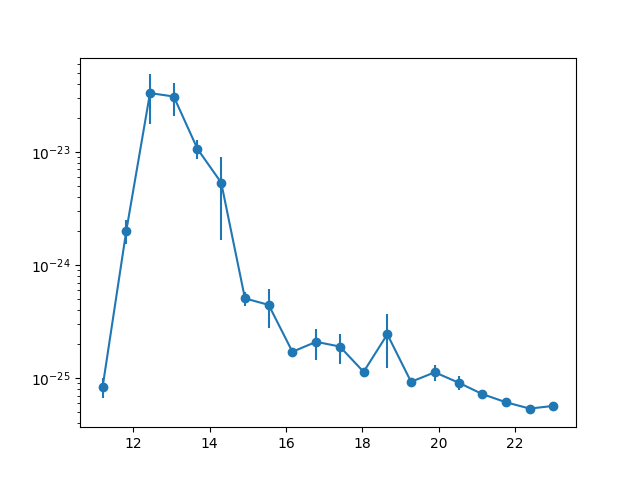

In [188]:
fig=plt.figure()
ax=fig.gca()

ax.errorbar(-vs/(Const.km/Const.s),pv,dpv,marker='o')
#ax.plot(-vs/(Const.km/Const.s),pv,'ko-')

ax.set_yscale("log")

In [189]:
np.savetxt("velocity-profile.dat",np.vstack((vs,pv,dpv)).transpose())

In [184]:
ax.errorbar(-vs/(Const.km/Const.s),pv,dpv,marker='o')

<ErrorbarContainer object of 3 artists>